#  Convolutional Neural Network Tutorial

Mit diesem Notebook bietet eine erste einfache Einführung in die Verwendung von Convolutional Neural Networks.
Es werden alle wichtigen Schritte von durchgeführt und beschrieben die notwendig sind um ein Model zu erstellen, Trainingsdaten zu laden, das Model zu trainieren und anschließend zu bewerten.

Es wird ein CNN als binärer Klassifikator trainiert werden um Chihuahuas von Muffins zu unterscheiden. 
<img src="Notebook_Images/full.jpg">

https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

## Vorbereitungen

    1. Python installieren: https://www.python.org/downloads/
    2. Jupyter installiern: http://jupyter.org/install
        In commandprompt:
        python3 -m pip install --upgrade pip
        python3 -m pip install jupyter

## Laden der Bilder
Zunächst müssen die Daten zum Training geladen werden. Die einzelnen Dateien müssen dafür nach Klassen sortiert in Ordner vorhanden sein. <br>
* \Data
   * \Chihuahuas 
      *  img1.jpg
      *  img2.jpg
      *  img3.jpg 
   * \Muffins
       * img1.jpg 
       * img2.jpg 
       * img3.jpg 

Bilddateien aus diesen Ordnern werden geladen, skaliert und ein Array mit entsprechenden Labels erstellt. 

In [1]:
from dataset import DataLoader
import numpy as np
#Pfad zu den Ordnern mit den Bildern 
data_dir = '.\\Images\\chihuahua-muffin\\train'
image_height=171
image_width= 171
testset= DataLoader()
images, labels = testset.load_data(data_dir, image_height,image_width)
images, labels = testset.normalizeData(images, labels)

954


Um die Bilder nicht jedesmal neu laden zu müssen, stellt numpy eine sehr effizente Methode zur Verfügung um große Datenmengen als .npz-Datei zu speichern. Dafür müssen der Methode die Bilder und Labels als Numpy-Array übergeben werden. 

In [8]:
import numpy as np
filename= 'dog-vs-muffins.npz'
np.savez_compressed(filename,
                    images=images,
                    labels=labels)

In [4]:
dataset= np.load('dog-vs-muffins.npz')
labels=dataset['labels']
images=dataset['images']
#images= np.concatenate((images[labels ==0][:20], images[labels ==1][:20]) ,axis=0)
#labels= np.concatenate((labels[labels ==0][:20], labels[labels ==1][:20]) ,axis=0)
print('load %d files' %len(labels))

load 954 files


In [5]:
def plot(images_to_plot, predictions= np.array([]), titles=[]):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(images_to_plot)):
        ax = fig.add_subplot(4, 4, 1 + i, xticks=[], yticks=[])
        im = images_to_plot[i]
        if titles:
            ax.set_title(titles[i])
        if predictions.size:
            ax.set_xlabel('dog: %6.2f \n muffin %6.2f'
                      % (predictions[i][0], predictions[i][1]), fontsize=12)
        plt.imshow(im)
    
    plt.tight_layout()
    plt.show()

16


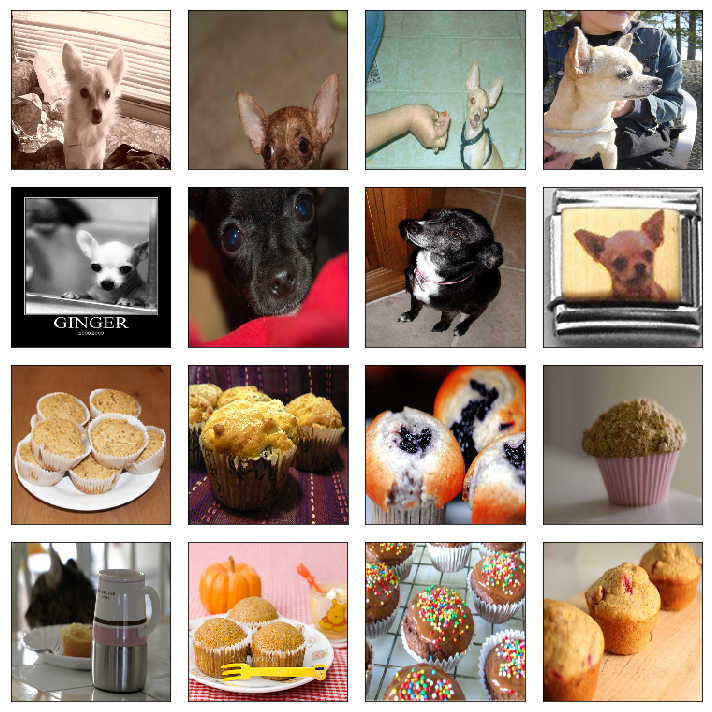

In [9]:
import matplotlib.pyplot as plt
images_to_show= np.concatenate((images[labels ==0][:8], images[labels ==1][:8]) ,axis=0)
print(len(images_to_show))

plot(images_to_show)

# Image Augmentation

Zur Vergrößerung der Datenmenge werden die Images bearbeitet. Für dieses Beispiel werden die Bilder vertikal oder horizontal gespiegelt zusätzlich wird von dem ursprünglichen Bild noch eine Kopie als Grauwertbild erzeugt.

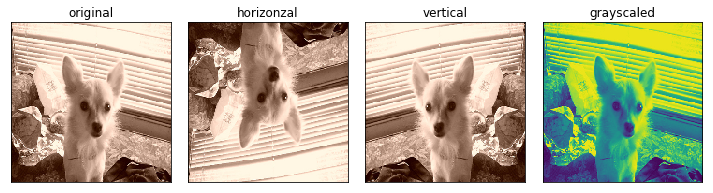

In [11]:
import cv2

img= images[0]

horizontal_flipt= cv2.flip(img, 0)
vertical_flipt= cv2.flip(img, 1)
gray_scaled_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

augmented_images= [img, horizontal_flipt, vertical_flipt, gray_scaled_img]
titels=['original', 'horizonzal', 'vertical', 'grayscaled']
plot(augmented_images, titles=titels)

def randomize_images(images,labels):

    for index in range(len(images)):
        img = images[index]
        flipt_img= cv2.flip(img, np.random.randint(0,1))
        flipt_img = np.expand_dims(flipt_img, axis=0)
        images=np.vstack((images, flipt_img))
        labels = np.append(labels, np.asarray(labels[index]))
    print(len(images))
    return images, labels

Zum lernen müssen die Daten durchmischt werden. Dadurch wird verhindert, dass der  

In [12]:
from sklearn.utils import shuffle
images , labels = shuffle(images , labels, random_state=9)

Anschließend werden die Daten in eine Trainings-, Validierungs- und Teststichprobe aufgeteilt. 
Trainings und Validierungsstichprobe werden zum anpassen der Gewichte beim Lernen verwendet. 
Die Teststichprobe muss vor der Trainingsphase abgespalten werden und dient dazu den Klassifikator nach dem Training 
zu bewerten.
<img src="Notebook_Images/Test-train-Val.PNG">


In [13]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

length=len(labels)

X_train = images[:int(length*0.8)]
X_val   = images[int(length*0.8):int(length*0.9)]
X_test  = images[int(length*0.9):]
y_train = labels[:int(length*0.8)] 
y_val   = labels[int(length*0.8):int(length*0.9)]
y_test  = labels[int(length*0.9):]

y_train= np_utils.to_categorical(y_train, 2)
y_val = np_utils.to_categorical(y_val, 2)

print("Trainingsdaten:", X_train.shape)
print("Validierungsdaten:", X_val.shape)
print("Testdaten:", X_test.shape)

d:\bibliotheken\python_352\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Trainingsdaten: (1270, 171, 171, 3)
Validierungsdaten: (159, 171, 171, 3)
Testdaten: (159, 171, 171, 3)


In [14]:
mean_values=np.mean(X_train, axis=0)
std_values=np.std(X_train)

x_train_centered= (X_train- mean_values)/std_values
x_val_centered= (X_val- mean_values)/std_values
x_test_centered= (X_test- mean_values)/std_values

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,  BatchNormalization, Dropout, Flatten, Dense
from keras.optimizers import SGD

model = Sequential()

model.add(Convolution2D(32, (5, 5), activation='relu',kernel_initializer='glorot_uniform', padding='same', 
                        input_shape=(image_height, image_width, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3),kernel_initializer='glorot_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3),kernel_initializer='glorot_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 171, 171, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 171, 171, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 85, 85, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 32)        9248      
__________

In [16]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)


model.fit(x_train_centered, y_train,
          batch_size=100,
          epochs=1,
          validation_data=(x_val_centered,  y_val),
          verbose=1,
          callbacks=[checkpointer])

Train on 1270 samples, validate on 159 samples
Epoch 1/1
1270/1270 [==============================] - 304s 239ms/step - loss: 0.9695 - acc: 0.6331 - val_loss: 0.6469 - val_acc: 0.6415


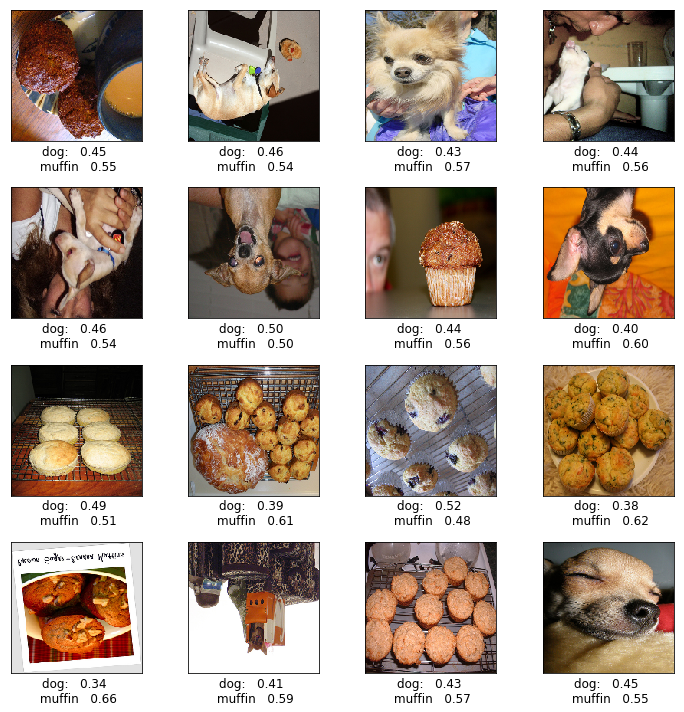

In [17]:
img_to_plot= X_test[:16]
predictions= model.predict(x_test_centered)[:16]

plot(img_to_plot, predictions= predictions)

In [18]:
true_labels=np_utils.to_categorical(y_test, 2)
metric= model.evaluate(x_test_centered, true_labels)

print('loss: %10.2f  \naccuracy: %6.2f' % (metric[0], metric[1]))

159/159 [==============================] - 9s 59ms/step
loss:       0.65  
accuracy:   0.63


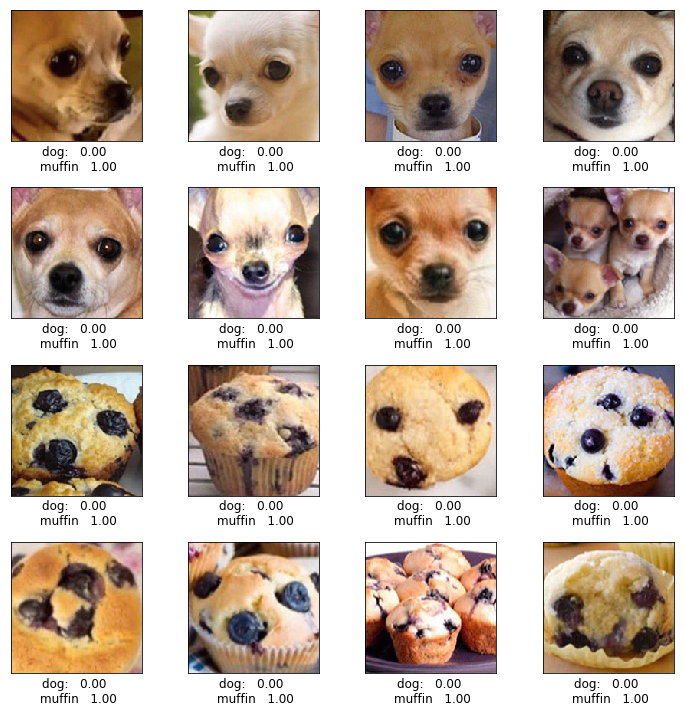

In [20]:
dataset= np.load('test-set.npz')
labels=dataset['labels']
images=dataset['images']

x_test_centered= (images- mean_values)/std_values
plot(images, predictions= model.predict(x_test_centered))

In [21]:
true_labels=np_utils.to_categorical(labels, 2)
metric= model.evaluate(x_test_centered, true_labels)

print('loss: %10.2f  \naccuracy: %6.2f' % (metric[0], metric[1]))

16/16 [==============================] - 1s 59ms/step
loss:       8.06  
accuracy:   0.50
